# Finding the road lanes using OpenCV

Description

First, as images tend to be distorted, I will use the OpenCV library to calibrate and undistort the input image

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import glob # To import all the calibration images

In [15]:
def calibrate():

    objp = np.zeros((6*8,3), np.float32) 
    objp[:,:2] = np.mgrid[0:8, 0:6].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    # Make a list of calibration images
    images = glob.glob('/Users/abylikhsanov1/AI/carnd/term1/advanced-lane-lines/camera_cal/calibration*.jpg') # Please update if needed
    for fname in images:
        image = cv2.imread(fname)
        gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
        ret, corners = cv2.findChessboardCorners(gray, (8,6), None) # Finding any distorted pixel locations
        if ret is True: # If we found any, we shall append the coordinates and the pixels itself
            objpoints.append(objp)
            imgpoints.append(corners)
            cv2.drawChessboardCorners(image, (8,6), corners, ret)
    cv2.destroyAllWindows()

Now, as we finished to get the distorted points from the sample images, we know our image points (pixels) which need to be undistorted and the constant object points (coordinates) as our final goal location.

In [14]:
def process_image(img):
    %matplotlib inline
    #img = cv2.imread('test_images/straight_lines1.jpg') # Now, let's undistort our first road image
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    # Calibrating and removing the distortion
    img_size = (img.shape[1],img.shape[0]) # We are making img_size[0] as x axis values and [1] as y axis
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints,img_size,None,None) # Calibration, moving imgpoints towards the coordinate
    dst = cv2.undistort(img, mtx, dist, None, mtx)

    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    ax1.imshow(img)
    ax1.set_title('Original Image', fontsize=30)
    ax2.imshow(dst)
    ax2.set_title('Undistorted Image', fontsize=30)

    
    combined_binary = gradient(dst)
    warped = warp(combined_binary)
    result,left_fitx,right_fitx = fit(warped)
    final = unwarp(result,img,left_fitx,right_fitx)
    return final

After our image undistortion, the next step will be to detect the gradients of the image using the Sobel operator. We will actually create 3 methods and choose one of them toidentify pixels where the gradient of an image falls within a specified threshold range.

In [4]:
# Full code, consists of 3 methods, the Sobel (x or y), the magniture (x and y combined) and the direction (the angle of the gradient)

def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Calculates the directional gradient
    # Apply threshold
    if orient == 'x':
        sobel = cv2.Sobel(img,cv2.CV_64F,1,0)
    elif orient == 'y':
        sobel = cv2.Sobel(img,cv2.CV_64F,0,1)
    sobel_abs = np.absolute(sobel)
    sobel_bin = np.uint8((255*sobel_abs/np.max(sobel_abs)))
    grad_binary = np.zeros_like(sobel_bin)
    grad_binary[(sobel_bin>=thresh[0])&(sobel_bin<=thresh[1])] = 1
    return grad_binary

def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Calculates the gradient magnitude
    # Apply threshold
    sobelx = cv2.Sobel(img,cv2.CV_64F,1,0)
    sobely = cv2.Sobel(img,cv2.CV_64F,0,1)
    sobel_abs = np.absolute(sobelx+sobely)
    sobel_bin = np.uint8((255*sobel_abs/np.max(sobel_abs)))
    mag_binary = np.zeros_like(sobel_bin)
    mag_binary[(sobel_bin>=mag_thresh[0])&(sobel_bin<=mag_thresh[1])] = 1
    return mag_binary

def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Calculates the gradient direction
    # Apply threshold
    sobelx = np.absolute(cv2.Sobel(img,cv2.CV_64F,1,0))
    sobely = np.absolute(cv2.Sobel(img,cv2.CV_64F,0,1))
    sobel_arctan = np.uint(np.arctan(sobely,sobelx))
    dir_binary = np.zeros_like(sobel_arctan)
    dir_binary[(sobel_arctan>=thresh[0])&(sobel_arctan<=thresh[1])] = 1
    return dir_binary

k_size = 7 # To make our image smoother, I have concluded, that this Kernel size is optimal.

#### IGNORE THE BELOW CODE IN THIS CELL, IT IS FOR THE TEST MODE ONLY ####

#gradx = abs_sobel_thresh(gray, orient='x', sobel_kernel=k_size, thresh=(10, 240))
#grady = abs_sobel_thresh(gray, orient='y', sobel_kernel=k_size, thresh=(30, 100))
#mag_binary = mag_thresh(gray, sobel_kernel=k_size, mag_thresh=(30, 100))
#dir_binary = dir_threshold(gray, sobel_kernel=k_size, thresh=(0.3, 1.3))

#combined = np.zeros_like(dir_binary)
#combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1

#plt.imshow(combined,cmap='gray')
#plt.show()

#hls = cv2.cvtColor(dst,cv2.COLOR_RGB2HLS)
#f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,10))
#ax1.set_title('Image in grayscale, H space')
#ax1.imshow(hls[:,:,0], cmap='gray')
#ax2.set_title('Image in grayscale, L space')
#ax2.imshow(hls[:,:,1], cmap='gray')
#ax3.set_title('Image in grayscale, S space')
#ax3.imshow(hls[:,:,2], cmap='gray')

Now, that we have defined our methods, we can experiment, which of them will work best with our image. We want to identify the line lanes. More over, in the next code cell, I will transform the image to HLS space, as you will see next, the "Saturation" value will make the non-white lanes more enhanced and actually performs good on shadows.

In [5]:
def gradient(dst):
    gray = cv2.cvtColor(dst,cv2.COLOR_RGB2GRAY)
    hls = cv2.cvtColor(dst,cv2.COLOR_RGB2HLS)

    # Sobel X on gray:
    sobel_gray = abs_sobel_thresh(gray, orient='x', sobel_kernel=k_size, thresh=(20, 200))

    # Sobel X on S (HLS):
    sobel_s = abs_sobel_thresh(hls[:,:,2], orient='x', sobel_kernel=k_size, thresh=(180, 255))

    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sobel_gray)
    combined_binary[(sobel_s == 1) | (sobel_gray == 1)] = 1

    # Plotting thresholded images
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    ax1.set_title('Stacked thresholds')
    ax1.imshow(dst)

    ax2.set_title('Combined S channel and gradient thresholds')
    ax2.imshow(combined_binary, cmap='gray')
    return combined_binary

Now, having a very good and enhanced lane lines, I will warp the image, in order to visualise the lanes in the right perspective (left and right lines have to be parallel). After warping the image (viewing from the top), the next task will be to construct the polynomial based on the line lanes.

In [6]:
# Time to warp the image
def warp(combined_binary):
    img_size = (combined_binary.shape[1],combined_binary.shape[0])
    bottom_left = [320,720] 
    bottom_right = [920, 720]
    top_left = [320, 1]
    top_right = [920, 1]
    src = np.float32([[256,688],[544,492],[752,492],[1044,688]])
    dest = np.float32([bottom_left,top_left,top_right,bottom_right])
    M = cv2.getPerspectiveTransform(src,dest)
    warped = cv2.warpPerspective(combined_binary,M,img_size)
# Plotting warped and non images
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    ax1.set_title('Combined S channel and gradient thresholds')
    ax1.imshow(combined_binary,cmap='gray')

    ax2.set_title('Warped image')
    ax2.imshow(warped, cmap='gray')
    return warped

In order to construct the polynomial across the lane lines, I will start by finding the most dense x axis pixel values. The function below explains how the x axis points are found and based on that, the best polynomial fit is being drawn, which effectively are the lane lines.

In [7]:
def fit(warped):
    # Viewing the most dense pixel region (sum of 1 on the X scale)
    histogram = np.sum(warped[int(warped.shape[0]/2):,:],axis=0)
    plt.plot(histogram)
    out_img = warped

    #In order to fit the polynomial for the lines, I will divide the image by 2 on x axis, to seperate left and right lanes
    midpoint = int(histogram.shape[0]/2)
    left_side = np.argmax(histogram[:midpoint]) # Getting the most dense pixel region at x axis, argmax returns the index
    right_side = np.argmax(histogram[midpoint:]) + midpoint # Getting the most dense pixel region at x axis right side
# As the maximum Y value is 720, I will choose to divide it to 9 windows
    windows = 9

# Set height of windows
    window_height = np.int(warped.shape[0]/windows) # In this code, this is int size of 80 (80 pixels)

# Identify the x and y positions of all nonzero pixels in the image
    nonzero = warped.nonzero() # Pixel locations where pixel is 1, [1] = x, [0] = y
    nonzeroy = np.array(nonzero[0]) 
    nonzerox = np.array(nonzero[1])

# Current positions to be updated for each window
    leftx_current = left_side 
    rightx_current = right_side

# Set the width of the windows +/- margin
    margin = 100
# Set minimum number of pixels found to recenter window
    minpix = 50
# Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

# Step through the windows one by one
    for window in range(windows): # Looping in 9 steps
    # Identify window boundaries in x and y (and right and left)
        win_y_low = warped.shape[0] - (window+1)*window_height # Loop 1, 0+1 * 80 = 80 px
        win_y_high = warped.shape[0] - window*window_height # Loop 1, 0 px, this is a top value, as y values are from the top to the bottom
        win_xleft_low = left_side - margin # Setting the square boundaries, from the current found lane piece
        win_xleft_high = left_side + margin
        win_xright_low = right_side - margin
        win_xright_high = right_side + margin
    # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        (0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        (0,255,0), 2) 
    # Identify the nonzero pixels in x and y within the window
        left_nzero_values = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]  # Getting the pixel locations, where pixel>1
        right_nzero_values = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
    # Append these indices to the lists
        left_lane_inds.append(left_nzero_values) # Left_lane_inds is the list of pixel locations in that margin box
        right_lane_inds.append(right_nzero_values)
    # If you found > minpix pixels, recenter next window on their mean position
        if len(left_nzero_values) > minpix:
            leftx_current = np.int(np.mean(nonzerox[left_nzero_values])) # Enhance: Try to get the argmax of np.sum of the location
        if right_nzero_values.size > minpix:        
            rightx_current = np.int(np.mean(nonzerox[right_nzero_values])) # For all the x values with pixels>1, we get the mean of that


# Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
# Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds] # Get the
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
# Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    out_img = np.dstack((warped, warped, warped))*255
    window_img = np.zeros_like(out_img) # Getting the blank image to display the curves
# Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0] ) # All the y values
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+(right_fitx-left_fitx),ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))

# Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))

    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    plt.imshow(result)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)
    return result,left_fitx,right_fitx

After finding the polynomials, the next step is to unwarp them into the original image.

In [8]:
def unwarp(result,img,left_fitx,right_fitx):
    bottom_left = [left_fitx[0],result.shape[0]] 
    bottom_right = [right_fitx[0], result.shape[0]]
    top_left = [left_fitx[-1], 0]
    top_right = [right_fitx[-1], 0]
    dest = np.float32([[256,688],[544,492],[752,492],[1044,688]])
    src = np.float32([bottom_left,top_left,top_right,bottom_right])
    img_size = (img.shape[1],img.shape[0])
    M = cv2.getPerspectiveTransform(src,dest)
    result_unwarp = cv2.warpPerspective(result,M,img_size)
# Plotting warped and non images
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255

    mask = np.zeros_like(result)
    vertices = np.array([[[256,688],[544,492],[752,492],[1044,688]]],dtype=np.int32)
    cv2.fillPoly(mask, vertices,ignore_mask_color)
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(result_unwarp, mask)
    final = cv2.addWeighted(img, 1, masked_image, 1, 1)
    f, (ax1) = plt.subplots(1, 1, figsize=(20,10))

    ax1.set_title('Warped image')
    ax1.imshow(final)
    return final
    #cv2.imwrite( "output_images/straight_lines1.jpg", cv2.cvtColor(final,cv2.COLOR_BGR2RGB));

In [9]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

[MoviePy] >>>> Building video output_videos/project_video.mp4
[MoviePy] Writing video output_videos/project_video.mp4


100%|█████████▉| 1260/1261 [12:57<00:00,  1.93it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/project_video.mp4 

CPU times: user 12min 46s, sys: 1min 12s, total: 13min 58s
Wall time: 12min 58s


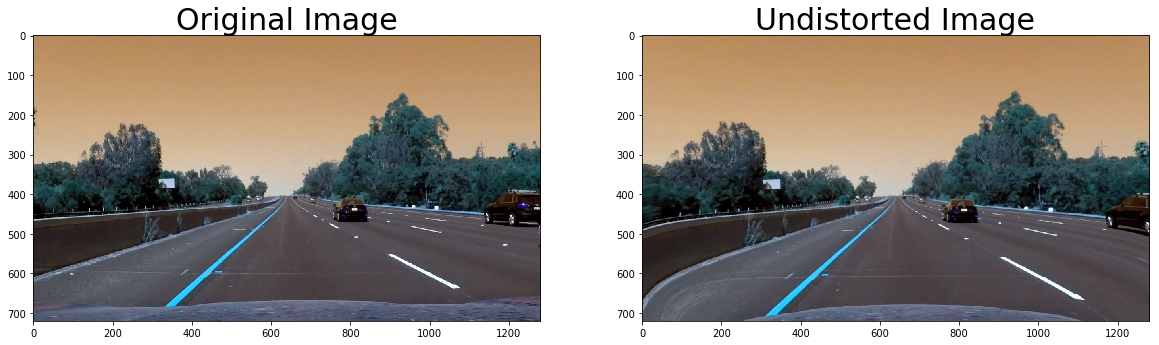

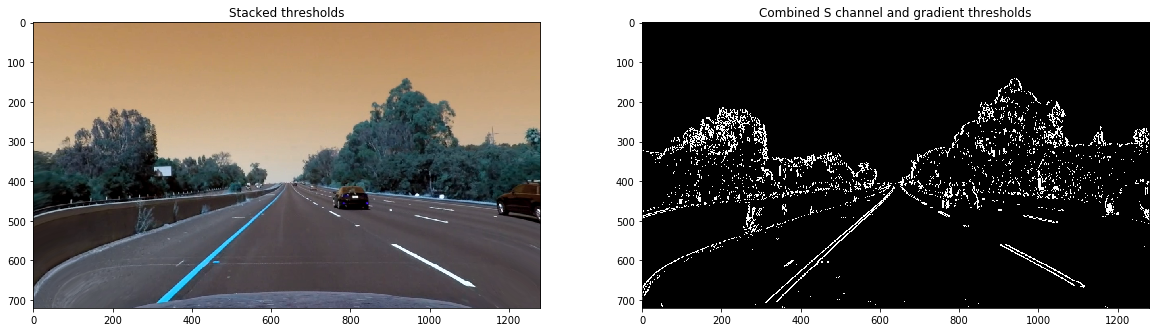

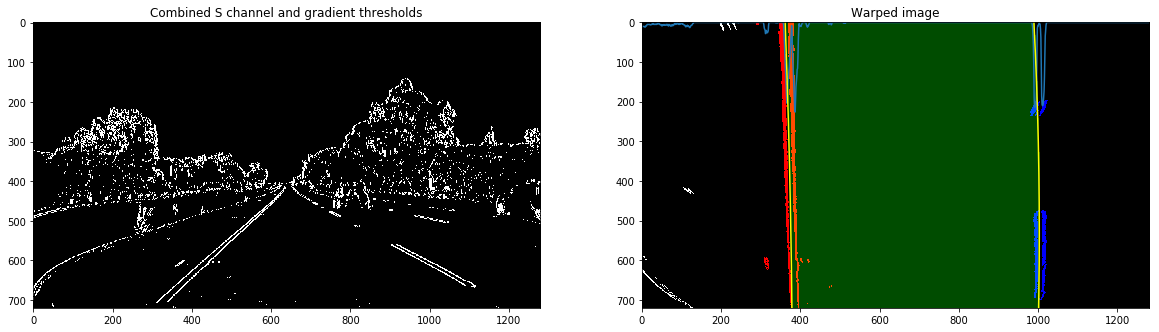

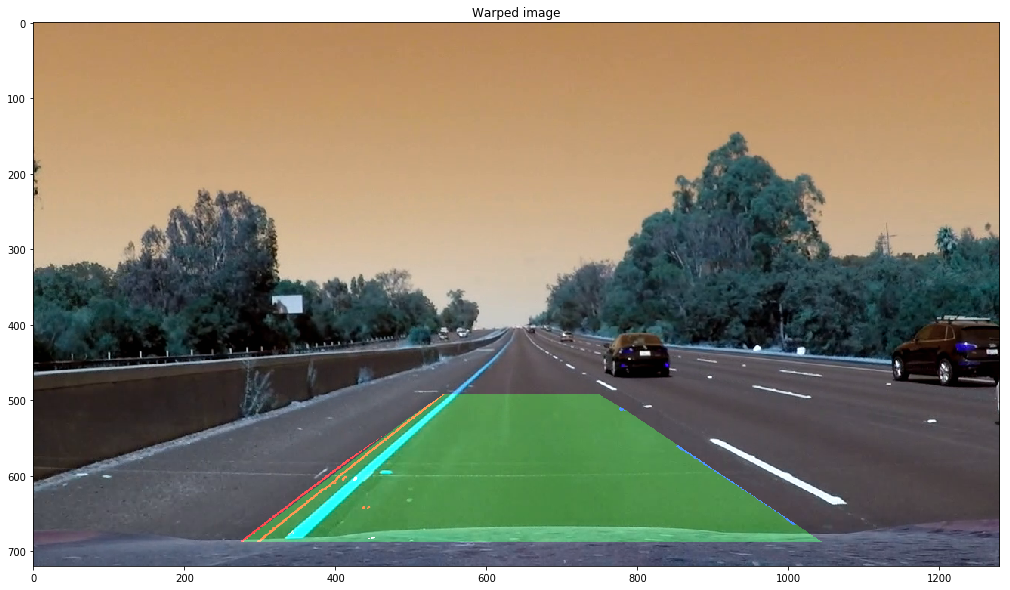

In [16]:
white_output = 'output_videos/project_video.mp4'
clip1 = VideoFileClip("project_video.mp4")
calibrate()
white_clip = clip1.fl_image(process_image) 
%time white_clip.write_videofile(white_output, audio=False)